In [115]:
import pandas as pd
import numpy as np
import librosa
import glob
import os

import IPython.display as ipd
import matplotlib.pyplot as plt
#import librosa.display

from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

In [ ]:
# do I need to use a wav file?
#filepath = "datasets/music_files/1_izumi_iori/clips/iori_1.mp3"
filepath = "datasets/music_files/1_izumi_iori/iori_1_test.wav"

In [ ]:
sample, sr = librosa.core.load(filepath)
#sample, sr = librosa.load(filepath)

ipd.Audio(sample, rate=sr)

In [2]:
# nope, mp3 works fine now
mp3_filepath = "datasets/music_files/1_izumi_iori/clips/iori_1.mp3"

sound_sample, sample_rate = librosa.core.load(mp3_filepath)
ipd.Audio(sound_sample, rate=sample_rate)

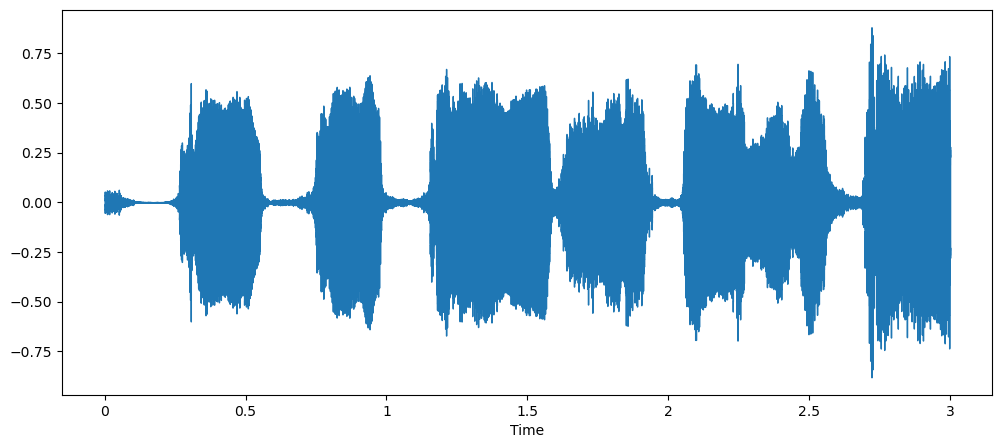

In [3]:
plt.figure(figsize=(12, 5))
librosa.display.waveshow(sound_sample, sr=sample_rate)

In [4]:
print(sample_rate)

22050


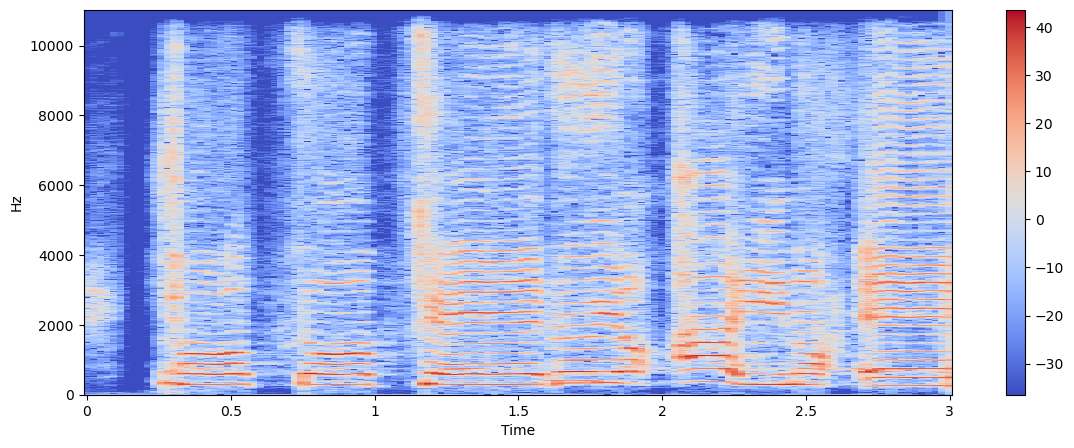

In [24]:
# make a spectrogram

sample_fourier = librosa.stft(sound_sample)
sample_amp = librosa.amplitude_to_db(abs(sample_fourier))
plt.figure(figsize=(14, 5))
librosa.display.specshow(sample_amp, sr=sample_rate, x_axis='time', y_axis='hz')
plt.colorbar()

In [25]:
# MFCC (Mel Frequency Cepstral Coefficients) transformation of audio data

print(librosa.feature.mfcc(y=sound_sample, sr=sample_rate))

[[-340.43198   -317.03458   -313.79077   ... -102.00902    -52.957687
   -33.538906 ]
 [   2.65505    -11.143518    -2.4876544 ...  -19.296566    16.94823
    47.646015 ]
 [-118.13782   -121.22456   -108.24842   ...  -24.118565   -17.372906
   -21.523409 ]
 ...
 [   4.327278    10.546621    11.863171  ...   -1.6404196    4.5649004
     6.422968 ]
 [   9.579963    10.616978     3.4575396 ...  -18.636726   -15.836746
    -9.19739  ]
 [   8.591682     9.0697       2.034244  ...    1.2939429   -1.5439465
    -2.9398124]]


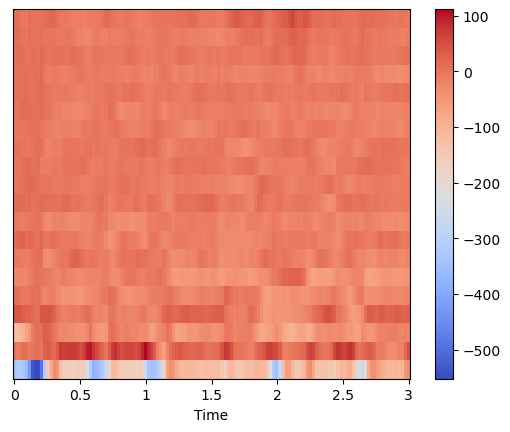

In [26]:
sample_mfcc = librosa.feature.mfcc(y=sound_sample, sr=sample_rate)

librosa.display.specshow(sample_mfcc, sr=sample_rate, x_axis='time')
plt.colorbar()

In [27]:
print(sample_mfcc.shape)

(20, 130)


In [6]:
# test of file list
test_path = "datasets/music_files/1_izumi_iori/clips"

test_file_list = glob.glob(os.path.join(os.getcwd(), test_path, "*.mp3"))

test_file_list[:5]

['C:\\Users\\kprie\\Documents\\Regis\\MSDS696_Practicum2\\project_material\\datasets/music_files/1_izumi_iori/clips\\iori_1.mp3',
 'C:\\Users\\kprie\\Documents\\Regis\\MSDS696_Practicum2\\project_material\\datasets/music_files/1_izumi_iori/clips\\iori_10.mp3',
 'C:\\Users\\kprie\\Documents\\Regis\\MSDS696_Practicum2\\project_material\\datasets/music_files/1_izumi_iori/clips\\iori_100.mp3',
 'C:\\Users\\kprie\\Documents\\Regis\\MSDS696_Practicum2\\project_material\\datasets/music_files/1_izumi_iori/clips\\iori_101.mp3',
 'C:\\Users\\kprie\\Documents\\Regis\\MSDS696_Practicum2\\project_material\\datasets/music_files/1_izumi_iori/clips\\iori_102.mp3']

In [7]:
os.path.basename(test_file_list[0])

'iori_1.mp3'

In [8]:
# dict reference {file_folder:singer_label}
singers = {"1_izumi_iori":"iori",}

# use the dict key to look up the filename
# dataframe columns: filename, label

# filepath = f"datasets/music_files/{file_folder}/clips/"

In [12]:
singers = {"1_izumi_iori":"iori",
          "2_nikaido_yamato":"yamato",
          "3_izumi_mitsuki":"mitsuki",
          "4_yotsuba_tamaki":"tamaki",
          "5_osaka_sougo":"sougo",
          "6_rokuya_nagi":"nagi",
          "7_nanase_riku":"riku",
          }

In [29]:
filenames = []
labels = []
folder = []

for file_folder, label in singers.items():
    
    filepath = f"datasets/music_files/{file_folder}/clips/"
    filelist = glob.glob(os.path.join(os.getcwd(), filepath, "*.mp3"))
    
    for file in filelist:
        filename = os.path.basename(file)
        
        folder.append(file_folder)
        filenames.append(filename)
        labels.append(singers[file_folder])

In [30]:
filename_dict = {"folder":folder,
                 "filenames":filenames,
                "labels":labels}

#print(filename_dict)

In [31]:
filename_df = pd.DataFrame(filename_dict)

filename_df.head()

,folder,filenames,labels
0,1_izumi_iori,iori_1.mp3,iori
1,1_izumi_iori,iori_10.mp3,iori
2,1_izumi_iori,iori_100.mp3,iori
3,1_izumi_iori,iori_101.mp3,iori
4,1_izumi_iori,iori_102.mp3,iori


In [32]:
filename_df.tail()

,folder,filenames,labels
994,7_nanase_riku,riku_95.mp3,riku
995,7_nanase_riku,riku_96.mp3,riku
996,7_nanase_riku,riku_97.mp3,riku
997,7_nanase_riku,riku_98.mp3,riku
998,7_nanase_riku,riku_99.mp3,riku


In [33]:
filename_df.count()

folder       999
filenames    999
labels       999
dtype: int64

In [109]:
filename_df['labels'].unique()

array(['iori', 'yamato', 'mitsuki', 'tamaki', 'sougo', 'nagi', 'riku'],
      dtype=object)

- Riku has the most samples because he's the lead singer of the group
- Mitsuki has a lot of samples (despite being the "weakest" singer because his 12 Gifts song is long and majority vocal - not as many musical breaks)

In [22]:
filename_df['labels'].value_counts()

riku       163
mitsuki    157
tamaki     145
yamato     141
nagi       133
iori       132
sougo      128
Name: labels, dtype: int64

In [38]:
# transform audio data into MFCCs

def features_extractor(file):
    
    
    #load audio file - get sound_sample and sample_rate
    audio, sample_rate = librosa.load(file) 
    #extract mfcc (default nmfcc=20)
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    #reduce dimensionality for scaled feature by calculating mean
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    return mfccs_scaled_features

In [65]:
# iterate through all audio files and extract features

extracted_features=[]

for index_num,row in filename_df.iterrows():
    
    file_folder = row['folder']
    dataset_path = f"datasets/music_files/{file_folder}/clips/"
    
    filepath = os.path.join(os.getcwd(), dataset_path, row['filenames'])
    #file_name = os.path.join(os.path.abspath(audio_dataset_path),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    #class_labels=row["labels"]
    
    feature_data=features_extractor(filepath)
    #filename_df['feature'] = feature_data
    extracted_features.append(feature_data)

In [66]:
filename_df['features'] = extracted_features

filename_df.head()

,folder,filenames,labels,features
0,1_izumi_iori,iori_1.mp3,iori,"[-170.33115, 28.068624, -37.377144, -0.1349895..."
1,1_izumi_iori,iori_10.mp3,iori,"[-173.79309, 30.538353, -18.663185, 1.4377732,..."
2,1_izumi_iori,iori_100.mp3,iori,"[-166.31758, 45.28576, 3.0837045, 6.9542723, -..."
3,1_izumi_iori,iori_101.mp3,iori,"[-177.42793, 58.64055, -4.903782, 3.8694122, -..."
4,1_izumi_iori,iori_102.mp3,iori,"[-201.73615, 52.32229, -1.105641, 13.764314, -..."


In [67]:
# checking the value for the first row of data
# checking the shape of the array
filename_df['features'][0]

array([-1.7033115e+02,  2.8068624e+01, -3.7377144e+01, -1.3498957e-01,
       -2.2997559e+01, -2.9723005e+01, -1.2476011e+01, -1.0493892e+01,
       -1.9704035e+01, -1.7335137e+00, -8.5586987e+00, -4.3690500e+00,
       -6.4758391e+00, -1.0527977e+01, -1.4234488e+01, -3.2545865e+00,
       -1.3757113e+01, -4.3118528e-01, -5.0311551e+00,  5.9845176e+00,
        3.4436026e+00,  7.7222676e+00,  1.5074942e+01,  1.9149330e+01,
        9.8382549e+00,  8.6514177e+00, -4.3541417e+00, -3.9527316e+00,
        3.1173119e-02,  5.2931881e+00, -2.2910469e+00, -6.9196904e-01,
       -9.1805973e+00, -1.7978026e+00,  6.4412820e-01,  2.0511003e+00,
       -2.4238820e+00,  1.5907388e+00, -2.1208417e-01,  2.4425571e+00],
      dtype=float32)

In [69]:
# length of a feature array - this will be used in model input shape

len(filename_df['features'][0])

40

## model building

In [70]:
### Split the dataset into independent and dependent dataset
X=np.array(filename_df['features'].tolist())
y=np.array(filename_df['labels'].tolist())

In [71]:
# change word category labels into numerical category labels
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

### Map of class labels to categorical numberical labels

- 0 = iori
- 1 = yamato
- 2 = mitsuki
- 3 = tamaki
- 4 = sougo
- 5 = nagi
- 6 = riku

In [72]:
y[:5]

array([[1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [73]:
### Train Test Split

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=97)

- 799 samples in training data
- 200 records in test data

In [74]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(799, 40)
(200, 40)
(799, 7)
(200, 7)


In [75]:
X_train.ndim

2

In [76]:
# number of classes (label categories)
num_labels=y.shape[1]

print(num_labels)

7


In [77]:
model=Sequential()
###first layer
model.add(Dense(100,input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###third layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [78]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [79]:
num_epochs = 100
num_batch_size = 32
checkpointer = ModelCheckpoint(filepath='./audio_classification.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()
model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)
duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100
22/25 [=========================>....] - ETA: 0s - loss: 35.7633 - accuracy: 0.1520
Epoch 1: val_loss improved from inf to 3.85306, saving model to .\audio_classification.hdf5
25/25 [==============================] - 1s 26ms/step - loss: 33.8500 - accuracy: 0.1489 - val_loss: 3.8531 - val_accuracy: 0.2100
Epoch 2/100
24/25 [===========================>..] - ETA: 0s - loss: 14.5921 - accuracy: 0.1667
Epoch 2: val_loss improved from 3.85306 to 2.10449, saving model to .\audio_classification.hdf5
25/25 [==============================] - 0s 11ms/step - loss: 14.3633 - accuracy: 0.1665 - val_loss: 2.1045 - val_accuracy: 0.1500
Epoch 3/100
22/25 [=========================>....] - ETA: 0s - loss: 8.6015 - accuracy: 0.1591
Epoch 3: val_loss improved from 2.10449 to 2.00215, saving model to .\audio_classification.hdf5
25/25 [==============================] - 0s 11ms/step - loss: 8.3537 - accuracy: 0.1640 - val_loss: 2.0022 - val_accuracy: 0.1750
Epoch 4/100
21/25 [==================

In [80]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.8700000047683716


In [81]:
predict_x=model.predict(X_test) 
classes_x=np.argmax(predict_x,axis=1)
print(classes_x)

7/7 [==============================] - 0s 3ms/step
[3 1 5 3 6 1 5 6 0 6 0 1 4 1 1 5 3 4 4 6 1 1 2 1 4 0 3 1 0 0 1 4 0 1 1 6 2
 5 2 0 6 1 1 0 3 4 3 5 4 4 4 6 4 2 2 0 6 1 1 6 4 1 2 1 5 4 2 6 0 3 0 5 0 4
 3 2 6 0 0 1 5 5 5 6 0 4 3 3 6 6 2 0 4 2 4 1 2 0 0 3 0 4 4 2 0 6 5 6 2 5 1
 4 5 6 5 3 3 6 4 1 4 2 0 1 5 3 1 5 3 1 3 6 5 6 1 0 2 4 0 0 5 2 4 4 0 1 2 0
 2 4 4 2 6 5 0 5 4 6 0 3 3 5 6 4 0 5 6 2 1 5 1 5 3 0 3 6 4 5 4 5 5 2 0 4 2
 5 6 0 4 2 4 5 4 6 3 0 5 6 2 1]


In [88]:
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [90]:
np.argmax(y_test,axis=1)

array([3, 1, 5, 3, 6, 1, 5, 6, 0, 1, 0, 1, 4, 3, 1, 5, 3, 4, 4, 6, 1, 1,
       2, 1, 4, 2, 3, 1, 0, 0, 1, 3, 0, 6, 6, 6, 2, 5, 2, 0, 6, 1, 1, 0,
       3, 4, 3, 5, 4, 4, 4, 6, 4, 2, 2, 0, 6, 1, 1, 6, 4, 1, 2, 1, 5, 4,
       2, 6, 0, 3, 0, 5, 0, 4, 3, 5, 6, 0, 0, 1, 5, 5, 5, 6, 0, 4, 3, 3,
       4, 6, 2, 0, 5, 2, 0, 1, 2, 0, 0, 3, 0, 4, 1, 2, 0, 1, 0, 6, 2, 5,
       1, 4, 5, 6, 5, 3, 3, 6, 4, 1, 4, 2, 0, 4, 5, 3, 1, 5, 3, 1, 3, 6,
       0, 6, 6, 0, 2, 0, 2, 0, 5, 2, 4, 4, 0, 6, 2, 0, 2, 4, 3, 2, 6, 0,
       0, 5, 0, 6, 0, 3, 3, 5, 6, 4, 6, 5, 6, 2, 1, 5, 1, 5, 3, 0, 3, 6,
       0, 5, 4, 5, 5, 2, 0, 1, 2, 5, 6, 0, 4, 2, 4, 5, 4, 6, 3, 0, 0, 6,
       2, 1], dtype=int64)

In [91]:
true_labels_ytest = np.argmax(y_test,axis=1)

In [104]:
true_labels_ytest.shape

(200,)

In [89]:
#true_labels_ytest = labelencoder.inverse_transform(y_test)

ValueError: y should be a 1d array, got an array of shape (200, 7) instead.

In [94]:
predictions = np.array(classes_x)

In [95]:
predictions

array([3, 1, 5, 3, 6, 1, 5, 6, 0, 6, 0, 1, 4, 1, 1, 5, 3, 4, 4, 6, 1, 1,
       2, 1, 4, 0, 3, 1, 0, 0, 1, 4, 0, 1, 1, 6, 2, 5, 2, 0, 6, 1, 1, 0,
       3, 4, 3, 5, 4, 4, 4, 6, 4, 2, 2, 0, 6, 1, 1, 6, 4, 1, 2, 1, 5, 4,
       2, 6, 0, 3, 0, 5, 0, 4, 3, 2, 6, 0, 0, 1, 5, 5, 5, 6, 0, 4, 3, 3,
       6, 6, 2, 0, 4, 2, 4, 1, 2, 0, 0, 3, 0, 4, 4, 2, 0, 6, 5, 6, 2, 5,
       1, 4, 5, 6, 5, 3, 3, 6, 4, 1, 4, 2, 0, 1, 5, 3, 1, 5, 3, 1, 3, 6,
       5, 6, 1, 0, 2, 4, 0, 0, 5, 2, 4, 4, 0, 1, 2, 0, 2, 4, 4, 2, 6, 5,
       0, 5, 4, 6, 0, 3, 3, 5, 6, 4, 0, 5, 6, 2, 1, 5, 1, 5, 3, 0, 3, 6,
       4, 5, 4, 5, 5, 2, 0, 4, 2, 5, 6, 0, 4, 2, 4, 5, 4, 6, 3, 0, 5, 6,
       2, 1], dtype=int64)

In [97]:
predictions.shape

(200,)

In [99]:
pd.Series(predictions)

0      3
1      1
2      5
3      3
4      6
      ..
195    0
196    5
197    6
198    2
199    1
Length: 200, dtype: int64

In [100]:
predictions_col = pd.Series(predictions)

In [102]:
true_col = pd.Series(true_labels_ytest)

In [105]:
pd.DataFrame(predictions_col)

,0
0,3
1,1
2,5
3,3
4,6
...,...
195,0
196,5
197,6
198,2


In [107]:
pd.DataFrame({'predictions':predictions_col, 'true_label':true_col})

,predictions,true_label
0,3,3
1,1,1
2,5,5
3,3,3
4,6,6
...,...,...
195,0,0
196,5,0
197,6,6
198,2,2


In [112]:
cm = pd.DataFrame(
    confusion_matrix(true_col, predictions_col))

cm

,0,1,2,3,4,5,6
0,30,0,0,0,4,4,0
1,0,24,0,0,2,0,2
2,2,0,23,0,0,0,0
3,0,1,0,21,2,0,0
4,0,1,0,0,25,0,1
5,0,0,1,0,1,26,0
6,1,4,0,0,0,0,25


In [113]:
cm = pd.DataFrame(
    confusion_matrix(true_col, predictions_col),
    columns=['pred_iori',
             'pred_yamato',
            'pred_mitsuki',
            'pred_tamaki',
            'pred_sougo',
            'pred_nagi',
            'pred_riku'],
    index=['true_iori',
             'true_yamato',
            'true_mitsuki',
            'true_tamaki',
            'true_sougo',
            'true_nagi',
            'true_riku']
)

cm

,pred_iori,pred_yamato,pred_mitsuki,pred_tamaki,pred_sougo,pred_nagi,pred_riku
true_iori,30,0,0,0,4,4,0
true_yamato,0,24,0,0,2,0,2
true_mitsuki,2,0,23,0,0,0,0
true_tamaki,0,1,0,21,2,0,0
true_sougo,0,1,0,0,25,0,1
true_nagi,0,0,1,0,1,26,0
true_riku,1,4,0,0,0,0,25


- the most incorrectly predicted person is Iori
    - equally mistaken for Sougo (4 out of 38) and Nagi (4 out of 38)
- Riku is most commonly mistaken for Yamato
- most test data is for Iori (38 samples), least for Tamaki (24 samples)
- Iori, Mitsuki, Tamaki, and Riku have better precision
- Yamato, Sougo, and Nagi have better recall
- overall precision and recall averages are similar (88% precision vs 87% recall)
- highest f1 score (Mitsuki), lowest f1 score (Sougo)

- Iori: precision > recall
- Yamato: precision < recall
- Mitsuki: precision > recall
- Tamaki: precision > recall
- Sougo: precision < recall
- Nagi: precision < recall
- Riku: precision > recall

In [116]:
print(classification_report(true_col, predictions_col))

              precision    recall  f1-score   support

           0       0.91      0.79      0.85        38
           1       0.80      0.86      0.83        28
           2       0.96      0.92      0.94        25
           3       1.00      0.88      0.93        24
           4       0.74      0.93      0.82        27
           5       0.87      0.93      0.90        28
           6       0.89      0.83      0.86        30

    accuracy                           0.87       200
   macro avg       0.88      0.88      0.87       200
weighted avg       0.88      0.87      0.87       200

